In [4]:
#!cat /proc/cpuinfo
!cat /proc/meminfo

MemTotal:       33397728 kB
MemFree:        23018336 kB
HighTotal:             0 kB
HighFree:              0 kB
LowTotal:       33397728 kB
LowFree:        23018336 kB
SwapTotal:       5242880 kB
SwapFree:        5242880 kB


# 0. Check GPU Infos

In [58]:
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPUs numbers: \t", len(GPUs))
print("GPU name: \t", gpu.name)
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


GPUs numbers: 	 1
GPU name: 	 GeForce 940MX
GPU RAM Free: 527MB | Used: 1521MB | Util  74% | Total 2048MB


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print("TensorFlow Version: \t", tf.__version__)
print("Is TensorFlow built with CUDA : \t", tf.test.is_built_with_cuda())
print("Is TensorFlow built with GPU Support : \t", tf.test.is_built_with_gpu_support())
print("GPU Device Name: \t", tf.test.gpu_device_name())

TensorFlow Version: 	 2.0.0
Is TensorFlow built with CUDA : 	 True
Is TensorFlow built with GPU Support : 	 True
GPU Device Name: 	 /device:GPU:0


# 1. TensorFlow


## 1.0 Keras
- **Dense**: $\qquad$ layer of connected neurons

# 2. Data Preprocessing
## 2.1 Load Data

In [3]:
datasetPath = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
datasetPath

'C:\\Users\\SenLi\\.keras\\datasets\\auto-mpg.data'

In [4]:
columnNames = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
df_DataSet_Raw = pd.read_csv(datasetPath, names=columnNames, na_values = "?",
                          comment='\t', sep=" ", skipinitialspace=True)
df_DataSet_Raw.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 2. 2 Clean Data

In [5]:
print(df_DataSet_Raw.isna().sum(axis=0))
df_DataSet = df_DataSet_Raw.dropna()
print("df_DataSet_Raw Shape Before DropNA: \t\t", df_DataSet_Raw.shape)
print("df_DataSet     Shape After  DropNA: \t\t", df_DataSet.shape)
ss_Origin = df_DataSet.pop('Origin')
print("df_DataSet     Shape After  pop('Origin'): \t", df_DataSet.shape)

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
df_DataSet_Raw Shape Before DropNA: 		 (398, 8)
df_DataSet     Shape After  DropNA: 		 (392, 8)
df_DataSet     Shape After  pop('Origin'): 	 (392, 7)


The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

In [6]:
df_DataSet['USA'] = (ss_Origin == 1)*1.0
df_DataSet['Europe'] = (ss_Origin == 2)*1.0
df_DataSet['Japan'] = (ss_Origin == 3)*1.0
print("New df_DataSet shape:\t", df_DataSet.shape)
df_DataSet.tail()

New df_DataSet shape:	 (392, 10)


S:\Anaconda3_64bit\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
S:\Anaconda3_64bit\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
S:\Anaconda3_64bit\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 2.3 Split into TrainingSet and TestSet

In [7]:
df_TrainingSet = df_DataSet.sample(frac=0.8,random_state=0)
df_TestSet  = df_DataSet.drop(df_TrainingSet.index)
print("df_DataSet shape:\t", df_DataSet.shape)
print("df_TrainingSet shape:\t", df_TrainingSet.shape)
print("df_TestSet shape:\t", df_TestSet.shape)

df_DataSet shape:	 (392, 10)
df_TrainingSet shape:	 (314, 10)
df_TestSet shape:	 (78, 10)


# 2.4 Inspect the data

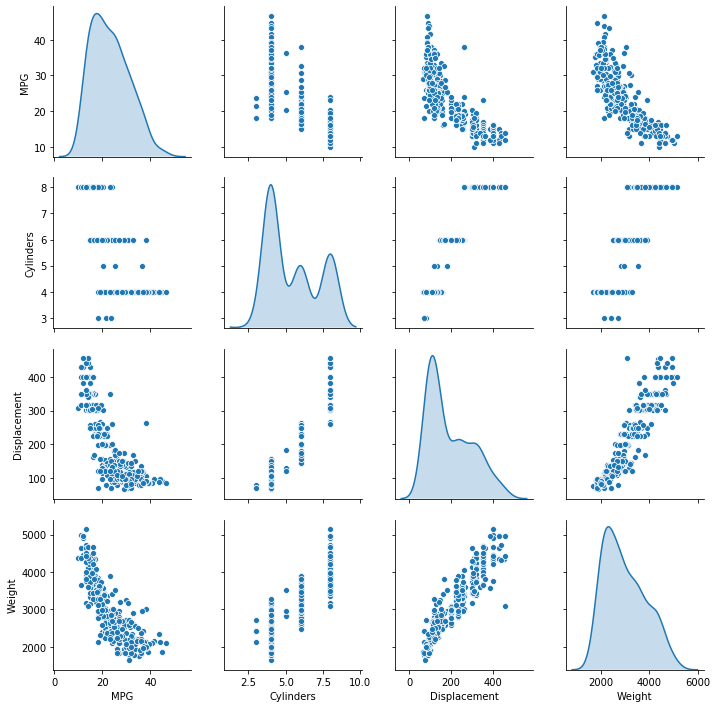

In [8]:
sns.pairplot(df_TrainingSet[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [9]:
df_Train_Stats = df_TrainingSet.describe()
df_Train_Stats.pop("MPG")
df_Train_Stats = df_Train_Stats.transpose()
df_Train_Stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 2.5 Split features from labels

In [10]:
ss_Train_Y = df_TrainingSet.pop('MPG')
ss_Test_Y = df_TestSet.pop('MPG')
print("ss_Train_Y shape:\t", ss_Train_Y.shape)
print("ss_Test_Y shape:\t", ss_Test_Y.shape)

ss_Train_Y shape:	 (314,)
ss_Test_Y shape:	 (78,)


## 2.6 Normalize the data
Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

In [11]:
'''
Note: 
    Although we intentionally generate these statistics from only the training dataset,
        these statistics will also be used to normalize the test dataset! 
    We need to do that to project the test dataset into the same distribution 
        that the model has been trained on.
'''
def normalize(X, mean_TrainingSet, std_TrainingSet):
    return (X - mean_TrainingSet) / std_TrainingSet

In [12]:
normaized_Train_X = normalize(df_TrainingSet, df_Train_Stats['mean'], df_Train_Stats['std'])
normaized_Test_X = normalize(df_TestSet, df_Train_Stats['mean'], df_Train_Stats['std'])
print("df_Train_Stats['mean'] shape:\t", df_Train_Stats['mean'].shape)
print("normaized_Train_X shape:\t", normaized_Train_X.shape)
normaized_Train_X

df_Train_Stats['mean'] shape:	 (9,)
normaized_Train_X shape:	 (314, 9)


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


# 3. Keras Model
## 3.1 Build the model

In [16]:
'''
    use a Sequential model with two densely connected hidden layers, 
    Output layer that returns a single, continuous value
'''

def getTwoLayersSequential(sizeInput, strActication, layerNodesCount):
    model = keras.Sequential([
        layers.Dense(layerNodesCount, activation=strActication, input_shape=[sizeInput]),
        layers.Dense(layerNodesCount, activation=strActication),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    return model

In [17]:
features_X = df_TrainingSet.keys()
features_X

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [22]:
sizeInput = len(features_X)
print("NN Input size = \t", sizeInput)

modelSequential = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[sizeInput]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
optimizer = tf.keras.optimizers.RMSprop(0.001)
modelSequential.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

modelSequential.summary()

NN Input size = 	 9
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## 3.2 Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [19]:
# Display training progress by printing a single dot for each completed epoch
class PrintEpochCompletedCount(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch == 0:
            print('\nEpoch Completed Count: \n', end='')
        elif (epoch + 1) % 100 == 0:
            print(epoch + 1)
        elif (epoch + 1) % 10 == 0:
            print(epoch + 1, end='\t')

In [27]:
SIZE_EPOCHS = 1000
VERBOSE_SILENT = 0

timeStart = time.time()

lossHistory_2 = modelSequential.fit(normaized_Train_X, ss_Train_Y, epochs=SIZE_EPOCHS, \
        validation_split = 0.2, verbose=VERBOSE_SILENT,callbacks=[PrintEpochCompletedCount()])

timeEnd = time.time()
runtime = timeEnd - timeStart
print('Two Layer Sequential {} epoches RunTime is {:.4f}'.format(SIZE_EPOCHS, runtime/60)+' mins')


Epoch Completed Count: 
10	20	30	40	50	60	70	80	90	100
110	120	130	140	150	160	170	180	190	200
210	220	

KeyboardInterrupt: 

In [106]:
tenHeadTestSetPredict = modelSequential.predict(normaized_Test_X[:10])
tenHeadTestSetPredict

array([[14.395184],
       [ 7.746042],
       [10.952344],
       [24.234613],
       [18.532412],
       [11.731063],
       [12.72727 ],
       [10.614869],
       [19.238914],
       [32.78697 ]], dtype=float32)

## 3.3 Visualize Loss History

In [29]:
df_LossHistory = pd.DataFrame(lossHistory.history)
df_LossHistory['epoch'] = lossHistory.epoch
df_LossHistory.tail()

,loss,mse,val_loss,val_mse,epoch
995,2.092345,2.092345,8.722128,8.722128,995
996,2.223942,2.223942,9.011415,9.011415,996
997,2.162183,2.162183,9.455682,9.455683,997
998,2.158683,2.158683,8.956048,8.956048,998
999,2.412047,2.412047,9.365426,9.365426,999


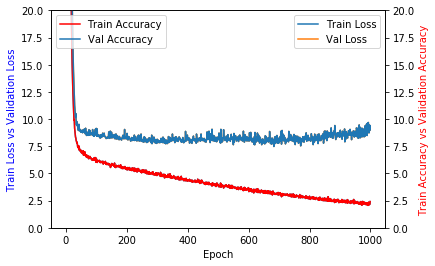

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.xlabel('Epoch'); 

ax1.set_ylabel('Train Loss vs Validation Loss', color='b')
ax1.plot(df_LossHistory['epoch'], df_LossHistory['loss'],     label = 'Train Loss')
ax1.plot(df_LossHistory['epoch'], df_LossHistory['val_loss'], label = 'Val Loss')
ax1.set_ylim([0,20]); ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel('Train Accuracy vs Validation Accuracy', color='r')
ax2.plot(df_LossHistory['epoch'], df_LossHistory['mse'],     'r-', label = 'Train Accuracy')
ax2.plot(df_LossHistory['epoch'], df_LossHistory['val_mse'], label = 'Val Accuracy')
ax2.set_ylim([0, 20]); 
ax2.legend(loc = 2)

In [98]:
def plot_LossHistory(lossHistory):
    df_LossHistory = pd.DataFrame(lossHistory.history)
    df_LossHistory['epoch'] = lossHistory.epoch

    plt.figure()
    plt.xlabel('Epoch'); plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['mae'],     label = 'Train Error')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['val_mae'], label = 'Val Error')
    plt.ylim([0,5]); plt.legend()

    plt.figure()
    plt.xlabel('Epoch'); plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['mse'],     label = 'Train Error')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['val_mse'], label = 'Val Error')
    plt.ylim([0,20]); plt.legend()
    plt.show()

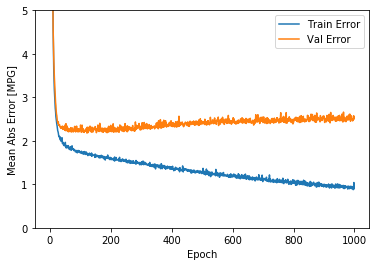

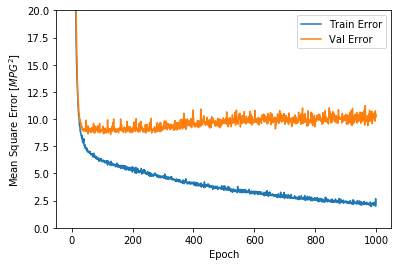

In [108]:
plot_LossHistory(lossHistory)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

## 3.4 Early Stop


Epoch Completed Count: 
10	20	30	40	50	60	

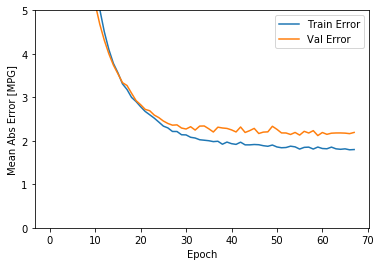

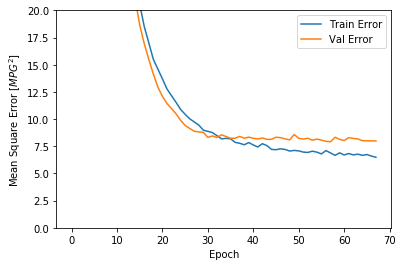

In [113]:
modelSequential = getTwoLayersSequential(sizeInput, 'relu', 64)

optimizer = tf.keras.optimizers.RMSprop(0.001)
modelSequential.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

# The patience parameter is the amount of epochs to check for improvement
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

earlyStop_LossHistory = modelSequential.fit(normaized_Train_X, ss_Train_Y, epochs=SIZE_EPOCHS, \
    validation_split = 0.2, verbose=VERBOSE_SILENT,callbacks=[earlyStop, PrintEpochCompletedCount()])

plot_LossHistory(earlyStop_LossHistory)

## 3.5 Evaluate Model


In [114]:
loss, mae, mse = modelSequential.evaluate(normaized_Test_X, ss_Test_Y, verbose=2)

print("TestSet Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.3504 - mae: 1.7582 - mse: 5.3504
TestSet Mean Abs Error:  1.76 MPG


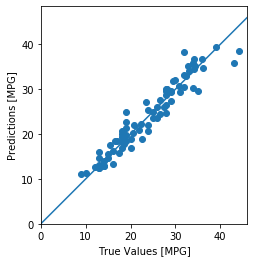

In [117]:
y_Test_Predict = modelSequential.predict(normaized_Test_X).flatten()

plt.scatter(ss_Test_Y, y_Test_Predict)
plt.xlabel('True Values [MPG]'); plt.ylabel('Predictions [MPG]')
plt.axis('equal'); plt.axis('square')
plt.xlim([0,plt.xlim()[1]]); plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well.

Text(0, 0.5, 'Count')

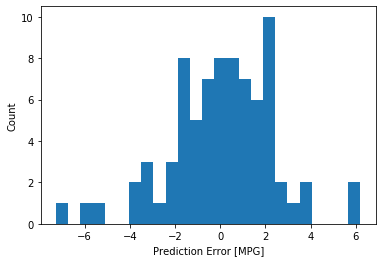

In [120]:
# look at the error distribution
ss_Error = y_Test_Predict - ss_Test_Y
plt.hist(ss_Error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.